# Summary


Depends on `elaspic_training_interface`.

----

# Imports

In [32]:
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-29 12:03:05.273178


In [33]:
%run db.ipynb

MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-29 12:03:05.532433


In [34]:
NOTEBOOK_NAME = 'interface_machine_learning'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [35]:
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE[:]

# Load data

In [36]:
DATA_DF = pd.read_pickle(op.join('interface_load_data', 'DATA_DF_TT.pkl'))  # with test / train split

In [37]:
DATA_DF.shape

(83480, 163)

In [38]:
DATA_DF.loc[DATA_DF['dataset'] == 'taipale', 'dataset'] = 'taipale_train'
DATA_DF.loc[DATA_DF['dataset'] == 'taipale_ppi', 'dataset'] = 'taipale_ppi_train'
DATA_DF.loc[DATA_DF['dataset'] == 'taipale_gpca', 'dataset'] = 'taipale_gpca_train'

In [39]:
DATA_DF.groupby(['dataset'])['dataset'].count()

dataset
ab_bind                   342
benedix_et_al             114
cagi4_sumo_ligase        3225
clinvar_test             4196
clinvar_train            6965
cosmic_test             25088
cosmic_train            31566
hiv_escape_mutations       23
humsavar_test            2676
humsavar_train           4873
skempi                   3412
taipale_gpca_train        179
taipale_ppi_train         267
taipale_train             554
Name: dataset, dtype: int64

In [40]:
all_results = DATA_DF.copy()

In [41]:
DATASETS = [
    'skempi',
    'taipale_train',
    'taipale_ppi_train',
    'taipale_gpca_train',
    'humsavar_train',
    'clinvar_train',
    'cosmic_train',
    # Test datasets (not used for cross-validation / feature elimination)
    'humsavar_test',
    'clinvar_test',
    'cosmic_test',
    #
    'cagi4_sumo_ligase',
    'ab_bind',
    'hiv_escape_mutations',
    'benedix_et_al',
]

In [42]:
all_results[all_results['dataset'] == 'ab_bind'].head(2)

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
421,1.0,1.0,NaN,NaN,1.0,1.0,-0.41394,2.28539,0.39852,-2.96249,NaN,NaN,NaN,NaN,C,0.0,0.0,NaN,NaN,NaN,NaN,0.669686,2.316060,NaN,NaN,NaN,NaN,ab_bind,NaN,2.184765,1.3,NaN,NaN,-1.07761,-3.04699,0.0,0.000000e+00,NaN,NaN,0.076265,-0.345444,1.037007,-1.67289,0.0,5.551120e-17,0.0,2.384,0.29724,1.94618,-0.27158,3.74864,NaN,0.0,-0.029492,NaN,NaN,NaN,NaN,NaN,2.0,"[1, 2]",NaN,NaN,893.155,163.970,1057.125,NaN,-0.6693,35.0678,-0.0071,70.8110,NaT,-2.0,100.0,0.0,0.0,NaN,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,D101A,,D311A,-0.729193,339.0,NaN,0.0,0.0,HL,None,NaN,0,0,0,0,0,0,0,0,0,0,0,0,-6,0,17,24,C,1dqj,C_D101A,None,NaN,NaN,NaN,-6.468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,NaN,1.24830,-6.04260,0.0,0.0,0.5041,-11.6149,-3.0277,15.8298,-7.747875,62.562789,"102.731,-206.699,-100.172,-378.594,-7.52855,50...","103.827,-207.978,-102.375,-379.722,-8.7808,510...",NaN,NaN,-0.034182,0.928992,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.86557,-2.17121,4.97405,-10.1908,0.0,0.0
422,2.0,1.0,NaN,NaN,1.0,1.0,-0.00118,2.71165,0.00627,-5.11072,NaN,NaN,NaN,NaN,A,0.0,0.0,NaN,NaN,NaN,NaN,0.825480,2.473449,NaN,NaN,NaN,NaN,ab_bind,NaN,0.730224,0.5,

In [43]:
pfam_a_clans = pd.read_sql_query('select * from pfam.pfam_a_clans', db_remote.engine)

In [44]:
pfam_a_clans.head()

,pfam_id,clan_id,clan_name,pfam_name,pfam_description
0,PF00389,CL0325,Form_Glyc_dh,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase,..."
1,PF00198,CL0149,CoA-acyltrans,2-oxoacid_dh,2-oxoacid dehydrogenases acyltransferase (cata...
2,PF04029,None,None,2-ph_phosp,2-phosphosulpholactate phosphatase
3,PF03171,CL0029,Cupin,2OG-FeII_Oxy,2OG-Fe(II) oxygenase superfamily
4,PF01073,CL0063,NADP_Rossmann,3Beta_HSD,3-beta hydroxysteroid dehydrogenase/isomerase ...


In [45]:
pfam_id_to_pfam_clan = {
    x[0]: x[1] for x in pfam_a_clans[['pfam_id', 'clan_id']].dropna().values
}

In [46]:
all_results['pfam_clan'] = all_results['pfam_id'].apply(lambda x: pfam_id_to_pfam_clan.get(x, x))

In [47]:
all_results[all_results['pfam_id'].notnull()][['pfam_id', 'pfam_clan']].tail()

,pfam_id,pfam_clan
93192,PF00089,CL0124
93200,PF00089,CL0124
93205,PF00089,CL0124
93224,PF00089,CL0124
93232,PF00089,CL0124


## Leave class out group

In [48]:
training_dataset_name = 'skempi'

In [49]:
uniprot_id_to_pfam_clan = {
    k: v
    for k, v
    in all_results[['uniprot_id', 'pfam_clan']].dropna().values
}

In [50]:
pdb_id_to_pfam_clan = {
    k: v
    for k, v
    in all_results[['pdb_id', 'pfam_clan']].dropna().values
}

SyntaxError: invalid syntax (<ipython-input-50-3fdad27ff025>, line 6)

In [51]:
def get_lco_id(pfam_clan, uniprot_id, pdb_id):
    
    pfam_clan_from_uniprot = uniprot_id_to_pfam_clan.get(uniprot_id)
    pfam_clan_from_pdb = pdb_id_to_pfam_clan.get(pdb_id)

    if pd.notnull(pfam_clan):
        return pfam_clan    
    elif pd.notnull(pfam_clan_from_uniprot):
        return pfam_clan_from_uniprot
    elif pd.notnull(pfam_clan_from_pdb):
        return pfam_clan_from_pdb
    elif pd.notnull(uniprot_id):
        return uniprot_id
    elif pd.notnull(pdb_id):
        return pdb_id

In [52]:
all_results['lco_id'] = [
    get_lco_id(*x)
    for x in all_results[['pfam_clan', 'uniprot_id', 'pdb_id']].values
]

In [53]:
def get_class_sets(*, n_classes=6, **args):
    """
    args : Counter
        key : num rows assigned to that key
    """
    args = sorted(args.items(), key=lambda x: x[1], reverse=True)
    num_rows = sum(v[1] for v in args)
    rows_per_class = num_rows // n_classes + 1

    class_sets = []
    for i in range(n_classes):
        class_set = {args.pop(0)}
        while sum(v[1] for v in class_set) < rows_per_class:
            try:
                class_set.add(args.pop(-1))
            except IndexError:
                break
        class_sets.append(class_set)
    assert not args
    return class_sets

In [54]:
c = {
    str(k): v for k, v 
    in Counter(all_results[all_results['dataset'] == training_dataset_name]['lco_id']).items()
}
class_sets = get_class_sets(n_classes=4, **c)
print([sum(x[1] for x in d) for d in class_sets])

[1121, 876, 904, 511]


In [55]:
all_results['lco_group'] = None

for i, class_set in enumerate(class_sets):
    cs = {k[0] for k in class_set}
    print('{:d}:\t{}'.format(i, cs))
    all_results.loc[
        ((all_results['dataset'] == training_dataset_name) &
         (all_results['lco_id'].isin(cs))),
        'lco_group'] = i

assert all_results[all_results['dataset'] == training_dataset_name]['lco_group'].notnull().all()

0:	{'CL0005'}
1:	{'P01051', 'P07363', 'Q65914', 'CL0202', 'CL0318', 'CL0108', 'P21836', '1nmb', 'PF08917', 'P0AE67', 'CL0010', 'PF00141', '1dn2', 'P01552', '3hfm', 'P68799', 'CL0023', 'PF07924', 'P01062', 'Q03405', 'P0A9A6', 'PF09408', 'P0AD64', '1jrh', 'Q40059', 'CL0431', 'CL0117', 'CL0079', 'Q13191', 'P19909', 'P46672', 'P38507', 'P0A0L5', 'P80060', 'P15879', 'P62593', 'P36711', 'CL0208', 'Q5D734', 'P46655', 'CL0159', 'P12497', 'PF02312', 'P01006', 'PF03974', 'P01075', 'Q9HXB1', 'Q8H0K8', 'P11540', 'P10775', 'P01857', 'Q8JGG7'}
2:	{'P13479', 'PF00074', 'CL0124', 'P04482', 'CL0053', 'CL0353', 'P15260', 'CL0022', 'P00648', 'CL0072', 'P09883', 'CL0037'}
3:	{'P35804', 'CL0011', 'CL0454'}


In [56]:
print(sum(all_results['pfam_clan'].isnull()))
print(sum(all_results['lco_id'].isnull()))

82235
0


In [57]:
all_results_bak_2 = all_results.copy()

## TRAINING_SETS_NONULL

In [58]:
all_results = all_results_bak_2.copy()

In [59]:
# Remove rows with missing features
TRAINING_SETS_NONULL = OrderedDict()
for dataset in DATASETS:
    print(dataset)
    df = all_results[all_results['dataset'] == dataset]
    # df = elaspic.elaspic_predictor.format_mutation_features(df)
    # Keep mut, remove it in next step
    # df = elaspic.elaspic_predictor.convert_features_to_differences(df, True)
    _shape_before = df.shape[0]
    for f in elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE + ['ddg_exp']:
        num_null = df[f].isnull().sum()
        if num_null:
            print2("Null column: '{}'".format(f), num_null, x=40)
    df = df.dropna(subset=elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE, how='any')
    df = df.dropna(subset=['ddg_exp', 'del_score_exp', 'del_class_exp'], how='all')
    _shape_after = df.shape[0]
    TRAINING_SETS_NONULL[dataset] = df

    print2("Shape before:", "{:,d}".format(_shape_before), x=20)
    print2("Shape after:", "{:,d}".format(_shape_after), x=20)
    print2("Rows lost:", "{:,d}".format(_shape_before - _shape_after), x=20)
    print('-' * 40)

skempi
Shape before:       3,412
Shape after:        3,412
Rows lost:          0
----------------------------------------
taipale_train
Null column: 'provean_score'            1
Shape before:       554
Shape after:        553
Rows lost:          1
----------------------------------------
taipale_ppi_train
Shape before:       267
Shape after:        267
Rows lost:          0
----------------------------------------
taipale_gpca_train
Shape before:       179
Shape after:        179
Rows lost:          0
----------------------------------------
humsavar_train
Null column: 'provean_score'            172
Null column: 'ddg_exp'                  4873
Shape before:       4,873
Shape after:        4,701
Rows lost:          172
----------------------------------------
clinvar_train
Null column: 'provean_score'            71
Null column: 'ddg_exp'                  6965
Shape before:       6,965
Shape after:        6,894
Rows lost:          71
----------------------------------------
cosmic_train


In [60]:
with open(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl'), 'wb') as ofh:
    pickle.dump(TRAINING_SETS_NONULL, ofh)

# Cross-validation

## system_commands

In [63]:
SCRIPT_NAME = 'gridsearch.py'

In [64]:
# Generate a list of parameters that we want to try...
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE[:]
FEATURE_COLUMNS.remove('dg_change')

parameter_grid =  {
    'data_set': ['skempi'],
    'data_file': [op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl'))],
    'n_estimators': [2000],
    'loss': ['huber'],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6,   8, 10],
    'min_samples_leaf': [3, 5, 9, 13, 17,   21, 29],
    'max_features': [1.0, 0.3, 0.1,   0.8, 0.5],
    'alpha': [0.99, 0.95, 0.9, 0.8, 0.7, 0.5],
    'features': [':'.join(FEATURE_COLUMNS)],
}


def get_system_command(**params):
    system_command = (
        "{python} {script} {args}".format(
            python=sys.executable,
            script=op.abspath(op.join(NOTEBOOK_NAME, SCRIPT_NAME)),
            args=' '.join(sorted("--{} {}".format(*x) for x in params.items())))
    )
    return system_command


system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**parameter_grid))
]

print("Size of the parameter grid: ", len(system_commands))

Size of the parameter grid:  3360


In [65]:
system_commands[0]

(0,
 '/home/kimlab1/strokach/anaconda/bin/python /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/gridsearch.py --alpha 0.99 --data_file /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/TRAINING_SETS_NONULL.pkl --data_set skempi --features dg_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:van_der_waals_clashes_change:entropy_sidechain_change:entropy_mainchain_change:sloop_entropy_ch

## gridsearch.py

In [67]:
%%file $NOTEBOOK_NAME/$SCRIPT_NAME
import os
import os.path as op
import pickle
import json
import scipy as sp
import pandas as pd
import sqlalchemy as sa
from sklearn import ensemble, cross_validation, metrics
import elaspic


def cross_validate(train_df, valid_dfs, opts, features, do_xval, target='ddg_exp', label='lco_group'):
    # Initialize classifier
    clf = ensemble.GradientBoostingRegressor(**opts)
    
    # Keep track of results
    result = {}
    def add_stats(actual, predicted, suffix=''):
        result.update({
                'r2{}'.format(suffix): metrics.r2_score(actual, predicted),
                'pearsonr{}'.format(suffix): sp.stats.pearsonr(actual, predicted)[0],
                'spearmanr{}'.format(suffix): sp.stats.spearmanr(actual, predicted)[0],
            })

    # Cross-validation        
    if do_xval:
        preds = cross_validation.cross_val_predict(
            estimator=clf,
            X=train_df[features],
            y=train_df[target],
            cv=cross_validation.LeaveOneLabelOut(train_df[label].fillna('')),
            n_jobs=1,
        )
        add_stats(train_df[target], preds)

    # Fit the classifier
    clf.fit(train_df[features], train_df[target])

    # Validation on our 'test' sets
    for valid_name, valid_df in valid_dfs.items():
        valid_df['pred'] = clf.predict(valid_df[features])
        for col_name, do_abs in [
                ('ddg_exp', False),
                ('del_score_exp', False),
                ('del_score_exp', True),
                ('del_class_exp', False),
                ('del_class_exp', True)]:
            if not valid_df[col_name].notnull().all():
                continue
            actual = valid_df[col_name].abs() if do_abs else valid_df[col_name]
            predicted = valid_df['pred'].abs() if do_abs else valid_df['pred']
            suffix = '_{}_{}_vs_ddg{}'.format(valid_name, col_name, '_abs' if do_abs else '')
            add_stats(actual, predicted, suffix)
            for cutoff_name, cutoff_func in [
                    # This bit is different by 100x compared to CORE
                    ('gt80', lambda x: x > 0.80),
                    ('40to80', lambda x: (x <= 0.80) & (x > 0.40)),
                    ('lt40', lambda x: x <= 0.40)]:
                keep_idx = valid_df['alignment_identity'].apply(cutoff_func)
                if (~keep_idx).all():
                    print("No samples found for '{}'".format(suffix + '_' + cutoff_name))
                    continue
                add_stats(actual[keep_idx], predicted[keep_idx], suffix + '_' + cutoff_name)

    # DONE!
    return result


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_set', type=str, required=True)
    parser.add_argument('--data_file', type=str, required=True)
    parser.add_argument('--features', type=str, default=None)
    parser.add_argument('--do_xval', type=int, default=1)
    #
    parser.add_argument('--learning_rate', type=float, required=True)
    parser.add_argument('--max_depth', type=int, required=True)
    parser.add_argument('--min_samples_leaf', type=int, required=True)
    parser.add_argument('--max_features', type=float, required=True)
    parser.add_argument('--alpha', type=float, required=True)
    #
    parser.add_argument('--loss', type=str, default='huber')
    parser.add_argument('--n_estimators', type=int, default=3000)
    #
    args = parser.parse_args()

    with open(args.data_file, 'rb') as ifh:
        TRAINING_SETS = pickle.load(ifh)
    
    train_df = TRAINING_SETS[args.data_set]
    validation_dfs = {
        # Training / validation datasets
        **{
            key.replace('_train', ''): df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_train')
        },
        # Test datasets
        **{
            key: df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_test')
        },
    }
    clf_opts = {
        k: v for (k, v) in args.__dict__.items()
        if k not in ['data_set', 'data_file', 'features', 'do_xval']
    }
    features = args.features.split(':')
        
    clf_result = cross_validate(train_df, validation_dfs, clf_opts, features, do_xval=bool(args.do_xval))

    result = {'clf_opts': clf_opts, 'features': args.features, **clf_result}
    print(json.dumps(result))

Overwriting interface_machine_learning/gridsearch.py


In [68]:
!echo {system_commands[0][1]}

/home/kimlab1/strokach/anaconda/bin/python /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/gridsearch.py --alpha 0.99 --data_file /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/interface_machine_learning/TRAINING_SETS_NONULL.pkl --data_set skempi --features dg_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:van_der_waals_clashes_change:entropy_sidechain_change:entropy_mainchain_change:sloop_entropy_change:m

In [70]:
!{system_commands[0][1]} > {NOTEBOOK_NAME}/stdout.log 2> {NOTEBOOK_NAME}/stderr.log

In [71]:
!cat {NOTEBOOK_NAME}/stdout.log

{"spearmanr_clinvar_del_class_exp_vs_ddg_lt40": 0.16183593816498762, "pearsonr_cosmic_del_class_exp_vs_ddg_abs": 0.07632994206256623, "pearsonr_humsavar_del_class_exp_vs_ddg_abs": 0.16708743286519234, "r2_taipale_ddg_exp_vs_ddg_lt40": -1.1052960484024936, "spearmanr_cosmic_test_del_score_exp_vs_ddg_gt80": 0.07138828066684386, "r2_cosmic_del_class_exp_vs_ddg_abs_gt80": -20.275092951379374, "pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80": 0.18661599333577417, "pearsonr_humsavar_del_class_exp_vs_ddg": 0.17988474959779438, "spearmanr_humsavar_test_del_class_exp_vs_ddg_abs_gt80": 0.3385372274078608, "pearsonr": 0.3772425407863872, "pearsonr_cosmic_del_class_exp_vs_ddg_gt80": 0.07481992484141693, "r2_humsavar_test_del_class_exp_vs_ddg_40to80": -8.843123755696041, "r2_humsavar_test_del_class_exp_vs_ddg_abs": -8.703070428378238, "spearmanr_cosmic_test_del_class_exp_vs_ddg_abs_lt40": 0.040012291910799434, "pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80": 0.09280354264114195, "pearsonr

In [72]:
!cat {NOTEBOOK_NAME}/stderr.log

## QSUB

In [73]:
SUFFIX = '_7'
JOB_NAME = '{}{}'.format(SCRIPT_NAME.replace('.py', ''), SUFFIX)
PATH = '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'

In [74]:
print(JOB_NAME)

gridsearch_7


In [75]:
js = jobsubmitter.JobSubmitter(
    JOB_NAME, 'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
)

Using an existing folder for log output. This is dangerous!!!


In [76]:
js.job_name

'gridsearch_7'

In [77]:
with js.connect():
    js.submit(system_commands)

## Resubmit failed

In [72]:
# Get job status
gridsearch_results_1 = js.job_status(system_commands)
print(Counter(gridsearch_results_1['status']))

Counter({'error': 3360})


In [73]:
# Job statistics
failed = set(gridsearch_results_1[gridsearch_results_1['status'] != 'done']['job_id'])
system_commands_remaining = [x for x in system_commands if x[0] in failed]
system_commands_remaining = list(reversed(system_commands_remaining))
print(len(system_commands_remaining))

3360


In [74]:
assert not system_commands_remaining

AssertionError: 

## Results

In [36]:
ABS = ''

In [37]:
CORRELATION_TYPE = 'spearmanr'

In [38]:
# Compute FoldX correlations
foldx_corrs = {}

if ABS:
    abs_fn = lambda x: np.abs(x)
else:
    abs_fn = lambda x: x

foldx_corrs.update({
    CORRELATION_TYPE: sp.stats.spearmanr(
        TRAINING_SETS_NONULL[training_dataset_name]['dg_change'].values,
        TRAINING_SETS_NONULL[training_dataset_name]['ddg_exp'].values
    )[0],
    '{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): sp.stats.spearmanr(
        TRAINING_SETS_NONULL['taipale_ppi_train']['dg_change'].values,
        TRAINING_SETS_NONULL['taipale_ppi_train']['ddg_exp'].values
    )[0],
    '{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): sp.stats.spearmanr(
        TRAINING_SETS_NONULL['taipale_gpca_train']['dg_change'].values,
        TRAINING_SETS_NONULL['taipale_gpca_train']['ddg_exp'].values
    )[0],
    '{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): sp.stats.spearmanr(
        abs_fn(TRAINING_SETS_NONULL['humsavar_train']['dg_change']).values,
        TRAINING_SETS_NONULL['humsavar_train']['del_class_exp'].values
    )[0],
    '{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): sp.stats.spearmanr(
        abs_fn(TRAINING_SETS_NONULL['clinvar_train']['dg_change']).values,
        TRAINING_SETS_NONULL['clinvar_train']['del_class_exp'].values
    )[0],
    '{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): sp.stats.spearmanr(
        abs_fn(TRAINING_SETS_NONULL['cosmic_train']['dg_change']).values,
        TRAINING_SETS_NONULL['cosmic_train']['del_class_exp'].values
    )[0]
})

In [39]:
# Compute FoldX correlations at different sequence identity cutoffs
for cutoff_name, cutoff_func in [
        ('_gt80', lambda x: x > 0.80),
        ('_40to80', lambda x: (x <= 0.80) & (x > 0.40)),
        ('_lt40', lambda x: x <= 0.40)]:
    print(cutoff_name)
    foldx_corrs.update({
        '{}_taipale_ppi_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['taipale_ppi_train'][
                     TRAINING_SETS_NONULL['taipale_ppi_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].values,
            TRAINING_SETS_NONULL['taipale_ppi_train'][
                    TRAINING_SETS_NONULL['taipale_ppi_train']['alignment_identity'].apply(cutoff_func)
                ]['ddg_exp'].values
        )[0],
        '{}_taipale_gpca_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['taipale_gpca_train'][
                     TRAINING_SETS_NONULL['taipale_gpca_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].values,
            TRAINING_SETS_NONULL['taipale_gpca_train'][
                    TRAINING_SETS_NONULL['taipale_gpca_train']['alignment_identity'].apply(cutoff_func)
                ]['ddg_exp'].values
        )[0],
        '{}_humsavar_del_class_exp_vs_ddg{}{}'.format(CORRELATION_TYPE, ABS, cutoff_name): sp.stats.spearmanr(
            abs_fn(TRAINING_SETS_NONULL['humsavar_train'][
                     TRAINING_SETS_NONULL['humsavar_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change']).values,
            TRAINING_SETS_NONULL['humsavar_train'][
                     TRAINING_SETS_NONULL['humsavar_train']['alignment_identity'].apply(cutoff_func)
                ]['del_class_exp'].values
        )[0],
        '{}_clinvar_del_class_exp_vs_ddg{}{}'.format(CORRELATION_TYPE, ABS, cutoff_name): sp.stats.spearmanr(
            abs_fn(TRAINING_SETS_NONULL['clinvar_train'][
                     TRAINING_SETS_NONULL['clinvar_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change']).values,
            TRAINING_SETS_NONULL['clinvar_train'][
                     TRAINING_SETS_NONULL['clinvar_train']['alignment_identity'].apply(cutoff_func)
                ]['del_class_exp'].values
        )[0],
        '{}_cosmic_del_class_exp_vs_ddg{}{}'.format(CORRELATION_TYPE, ABS, cutoff_name): sp.stats.spearmanr(
            abs_fn(TRAINING_SETS_NONULL['cosmic_train'][
                     TRAINING_SETS_NONULL['cosmic_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change']).values,
            TRAINING_SETS_NONULL['cosmic_train'][
                     TRAINING_SETS_NONULL['cosmic_train']['alignment_identity'].apply(cutoff_func)
                ]['del_class_exp'].values
        )[0]
    })

_gt80
_40to80
_lt40


In [40]:
foldx_corrs.keys()

dict_keys(['spearmanr_taipale_ppi_ddg_exp_vs_ddg_40to80', 'spearmanr', 'spearmanr_humsavar_del_class_exp_vs_ddg_lt40', 'spearmanr_taipale_gpca_ddg_exp_vs_ddg_40to80', 'spearmanr_cosmic_del_class_exp_vs_ddg', 'spearmanr_cosmic_del_class_exp_vs_ddg_40to80', 'spearmanr_humsavar_del_class_exp_vs_ddg_40to80', 'spearmanr_cosmic_del_class_exp_vs_ddg_gt80', 'spearmanr_taipale_gpca_ddg_exp_vs_ddg_lt40', 'spearmanr_clinvar_del_class_exp_vs_ddg', 'spearmanr_clinvar_del_class_exp_vs_ddg_gt80', 'spearmanr_cosmic_del_class_exp_vs_ddg_lt40', 'spearmanr_clinvar_del_class_exp_vs_ddg_40to80', 'spearmanr_taipale_gpca_ddg_exp_vs_ddg_gt80', 'spearmanr_taipale_ppi_ddg_exp_vs_ddg_lt40', 'spearmanr_humsavar_del_class_exp_vs_ddg_gt80', 'spearmanr_taipale_gpca_ddg_exp_vs_ddg', 'spearmanr_taipale_ppi_ddg_exp_vs_ddg', 'spearmanr_humsavar_del_class_exp_vs_ddg', 'spearmanr_clinvar_del_class_exp_vs_ddg_lt40', 'spearmanr_taipale_ppi_ddg_exp_vs_ddg_gt80'])

In [41]:
# Prepare results for plotting
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1.5)

columns = [
    CORRELATION_TYPE, 
    '{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS),
    '{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS),
    '{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS),
    '{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE),
    '{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE),
]

_before = gridsearch_results_1.shape[0]
df = gridsearch_results_1.dropna(subset=[columns])
_after = df.shape[0]
print("Lost {} rows.".format(_before - _after))

print(gridsearch_results_1.shape)

# df['correlation_avg'] = df[columns].mean(axis=1)
df['correlation_avg'] = (
    df[CORRELATION_TYPE] * 3 + 
    df['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
    df['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
    df['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
    df['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
    df['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)]
)

df = df.sort_values('correlation_avg', ascending=True)
df.index = range(df.shape[0])

print(df.shape)
display(df[columns].iloc[-1])

Lost 0 rows.
(3360, 224)
(3360, 225)


spearmanr                                  0.562201
spearmanr_humsavar_del_class_exp_vs_ddg    0.257777
spearmanr_clinvar_del_class_exp_vs_ddg     0.138743
spearmanr_cosmic_del_class_exp_vs_ddg      0.105803
spearmanr_taipale_ppi_ddg_exp_vs_ddg       0.256793
spearmanr_taipale_gpca_ddg_exp_vs_ddg      0.315269
Name: 3359, dtype: float64

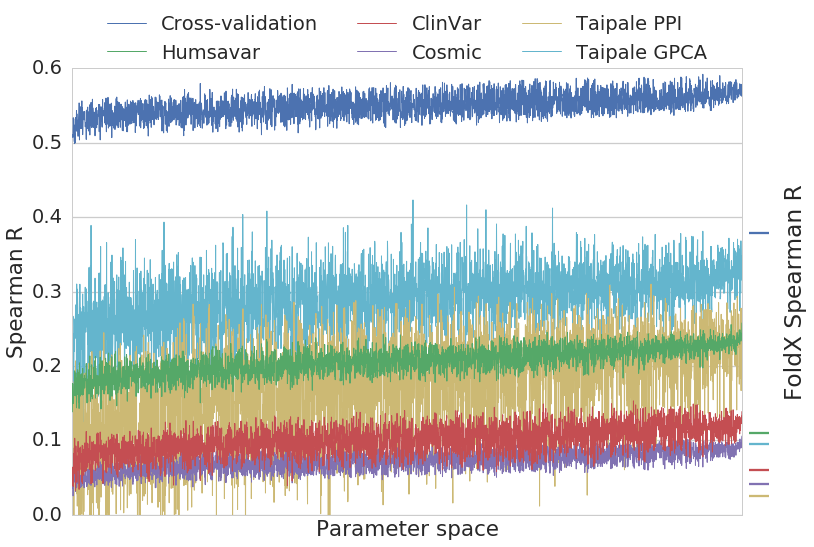

In [42]:
# Plot gridsearch over parameter space
fg, ax = plt.subplots(figsize=(12, 8))

ax = (
    df[columns]
    .rename(columns={
        CORRELATION_TYPE: 'Cross-validation', 
        '{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): 'Humsavar',
        '{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): 'ClinVar',
        '{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): 'Cosmic',
        '{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): 'Taipale PPI',
        '{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): 'Taipale GPCA',
        })
    .plot(xticks=[], ax=ax, linewidth=1)
)

for i, l in enumerate(ax.get_lines()):
    l.set_zorder(len(columns) - i)

ax.set_xlabel('Parameter space')
ax.set_ylabel('{} R'.format(CORRELATION_TYPE[:-1].capitalize()))
ax.set_ylim(0, 0.6)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)

text_xpos = ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.08
text_ypos = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2
ax.text(
    text_xpos, text_ypos, 'FoldX Spearman R', rotation=90,
    horizontalalignment='center', verticalalignment='center')

legend_xpos = [
    ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01,
    ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.04,
]

l = plt.hlines(
    [foldx_corrs[c] for c in columns],
    xmin=legend_xpos[0],
    xmax=legend_xpos[1],
    colors=sns.color_palette()[:len(columns)],
    linestyles='-')

l.set_clip_on(False)

plt.savefig(op.join(NOTEBOOK_NAME, 'gridsearch.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'gridsearch.pdf'), bbox_inches='tight')

In [43]:
df.tail(2)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_del_class_exp_vs_ddg_gt80,r2_clinvar_del_class_exp_vs_ddg_lt40,r2_clinvar_test_del_class_exp_vs_ddg,r2_clinvar_test_del_class_exp_vs_ddg_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs,r2_clinvar_test_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_test_del_class_exp_vs_ddg_gt80,r2_clinvar_test_del_class_exp_vs_ddg_lt40,r2_cosmi

In [44]:
df.loc[3359, 'clf_opts']

{'alpha': 0.7,
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 8,
 'max_features': 0.8,
 'min_samples_leaf': 13,
 'n_estimators': 2000}

In [45]:
df_bak = df.copy()

# Feature elimination

## Prepare

In [46]:
df = df_bak.copy()
clf_opts_best = df.iloc[-1]['clf_opts']
pprint(clf_opts_best)

{'alpha': 0.7,
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 8,
 'max_features': 0.8,
 'min_samples_leaf': 13,
 'n_estimators': 2000}


## QSUB

In [47]:
FE_SUFFIX = '_1'

In [48]:
JOB_NAME

'gridsearch_6'

In [49]:
_parameter_grid = {
    **{k: [v] for k, v in clf_opts_best.items()},
    'max_features': [
        min(1.0, clf_opts_best['max_features'] * len(FEATURE_COLUMNS) / len(FEATURE_COLUMNS))
    ],
    'features': [
        ':'.join(f for i, f in enumerate(FEATURE_COLUMNS) if i != skip_i) for skip_i in range(len(FEATURE_COLUMNS))
    ]
}

_system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
]


In [50]:
# Configure feature elimination
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE[:]
FEATURE_COLUMNS.remove('dg_change')

params = {
    **clf_opts_best,
    'data_set': training_dataset_name,
    'data_file': op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl')),
}


def run_feature_elimination(features):
    # Parameters
    _parameter_grid = {
        **{k: [v] for k, v in params.items()},
        'max_features': [
            min(1.0, params['max_features'] * len(FEATURE_COLUMNS) / len(features))
        ],
        'features': [
            ':'.join(f for i, f in enumerate(features) if i != skip_i) for skip_i in range(len(features))
        ]
    }
    _system_commands = [
        (i, get_system_command(**params)) 
        for i, params 
        in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
    ]

    # Run FE on cluster
    _js = jobsubmitter.JobSubmitter(
        'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, len(features)),
        'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
        email='ostrokach@gmail.com', force_new_folder=False,
        nproc=1, queue='medium', walltime='8:00:00', mem='6G',
        env={'PATH': PATH},
    )

#     _js = jobsubmitter.JobSubmitter(
#         'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, len(features)),
#         'pbs://:@192.168.233.150', op.abspath(NOTEBOOK_NAME),
#         email='ostrokach@gmail.com', force_new_folder=False,
#         nproc=1, queue='medium', walltime='06:00:00', mem='8G',
#         env={'PATH': PATH},
#         concurrent_job_limit=800
#     )
    print(_js.job_name)
    
    with _js.connect():
        _js.submit(_system_commands)
   
    # Get job status
    df = _js.job_status(_system_commands)
    time.sleep(10)
    print(Counter(df['status']))
    while not (df['status'] == 'done').all():
        time.sleep(60)
        df = _js.job_status(_system_commands)
        print(Counter(df['status']))

    df['correlation_avg'] = (
        df[CORRELATION_TYPE] * 3 + 
        df['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
        df['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
        df['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
        df['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
        df['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)]
    ) / 6.5

    df = df.sort_values('correlation_avg', ascending=True)
    
    print("Correlation AVG: {:5}".format(df.iloc[-1]['correlation_avg']))
    features_best = df.iloc[-1]['features'].split(':')
    
    run_feature_elimination(features_best)

In [51]:
# Configure feature elimination part-way
features = FEATURE_COLUMNS
n_features = 17

_parameter_grid = {
    **{k: [v] for k, v in params.items()},
    'max_features': [
        min(1.0, params['max_features'] * len(FEATURE_COLUMNS) / len(features))
    ],
    'features': [
        ':'.join(f for i, f in enumerate(features) if i != skip_i) for skip_i in range(len(features))
    ][:n_features]
}
_system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
]

# Run FE on cluster
_js = jobsubmitter.JobSubmitter(
    'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, n_features),
    'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
)
print(_js.job_name)

# Get job status
df = _js.job_status(_system_commands)
time.sleep(10)
print(Counter(df['status']))

df['correlation_avg'] = (
    df[CORRELATION_TYPE] * 3 + 
    df['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
    df['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
    df['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
    df['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
    df['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)]
) / 6.5

df = df.sort_values('correlation_avg', ascending=True)
print("Correlation AVG: {:5}".format(df.iloc[-1]['correlation_avg']))

features_best = df.iloc[-1]['features'].split(':')
assert len(features_best) == (n_features - 1)
print(features_best)

Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features17
Counter({'done': 17})
Correlation AVG: 0.38461923529260683
['solvation_polar_wt', 'partial_covalent_bonds_wt', 'number_of_residues', 'intraclashes_energy_1_change', 'backbone_hbond_change', 'sidechain_hbond_change', 'electrostatics_change', 'solvation_polar_change', 'solvation_hydrophobic_change', 'entropy_sidechain_change', 'backbone_clash_change', 'pcv_vdw_wt', 'pcv_hbond_self_change', 'pcv_vdw_self_change', 'provean_score', 'solvent_accessibility_change']


## Results

In [52]:
df.head(2)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_del_class_exp_vs_ddg_gt80,r2_clinvar_del_class_exp_vs_ddg_lt40,r2_clinvar_test_del_class_exp_vs_ddg,r2_clinvar_test_del_class_exp_vs_ddg_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs,r2_clinvar_test_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_test_del_class_exp_vs_ddg_gt80,r2_clinvar_test_del_class_exp_vs_ddg_lt40,r2_cosmi

In [53]:
# Read results
best_dfs = []
best_features = []

for n_features in range(len(FEATURE_COLUMNS), 1, -1):
    # Parameters
    _parameter_grid = {
        **{k: [v] for k, v in params.items()},
        'features': list(range(i)),
    }
    _system_commands = [
        (i, get_system_command(**params)) 
        for i, params 
        in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid.copy()))
    ]

    # Run FE on cluster
    _js = jobsubmitter.JobSubmitter(
        'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, n_features),
        'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
        email='ostrokach@gmail.com', force_new_folder=False,
        nproc=1, queue='medium', walltime='8:00:00', mem='6G',
        env={'PATH': PATH},
    )
    print(_js.job_name)
    
    # Get job status
    df = _js.job_status(_system_commands)
    df['n_features'] = df['features'].str.count(':') + 1
    _before = df.shape[0]
    df = df[df['n_features'] == (n_features - 1)]
    _after = df.shape[0]
    _n_lost = (_before - _after)
    if _n_lost:
        print(_js.job_name, end=' ')
        print("Wrong number of features for {} rows!".format(_before - _after))
        sys.stdout.flush()

    df['correlation_avg'] = (
        df[CORRELATION_TYPE] * 3 + 
        df['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
        df['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +  # not * 2
        df['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
        df['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
        df['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)]
    ) / 6.5
    df = df.sort_values('correlation_avg', ascending=True)
    best_dfs.append(df.iloc[-1:None])
    
    features = df.iloc[-1]['features'].split(':')
    best_features.append((i, len(features), features,))

#     best_correlation_avg = df.iloc[-1]['correlation_avg']
#     # print(best_correlation_avg)

#     best_scores.append((
#         i,
#         len(features),
#         df.iloc[-1]['correlation_avg'], 
#         df.iloc[-1][CORRELATION_TYPE], 
#         df.iloc[-1]['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)],
#         df.iloc[-1]['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)], 
#         df.iloc[-1]['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)], 
#         df.iloc[-1]['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)],
#         df.iloc[-1]['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)],
#     ))
best_df = pd.concat(best_dfs, ignore_index=True)

Using an existing folder for log output. This is dangerous!!!
Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features74


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features73


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features72


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features71


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features70


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features69


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features68


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features67


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features66


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features65


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features64


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features63


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features62


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features61


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features60


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features59


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features58


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features57


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features56


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features55


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features54


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features53


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features52


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features51
feature_elimination_6_1_features50


Using an existing folder for log output. This is dangerous!!!
Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features49


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features48


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features47


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features46


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features45


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features44


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features43


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features42


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features41


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features40


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features39


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features38


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features37


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features36


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features35


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features34


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features33


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features32


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features31


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features30


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features29


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features28


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features27


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features26


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features25


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features24


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features23


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features22


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features21


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features20


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features19


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features18


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features17


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features16


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features15


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features14


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features13


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features12


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features11


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features10


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features9


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features8


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features7


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features6


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features5
feature_elimination_6_1_features4
feature_elimination_6_1_features4 Wrong number of features for 1 rows!


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features3
feature_elimination_6_1_features3 Wrong number of features for 2 rows!


Using an existing folder for log output. This is dangerous!!!


feature_elimination_6_1_features2
feature_elimination_6_1_features2 Wrong number of features for 3 rows!


In [54]:
best_df.head()

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_del_class_exp_vs_ddg_gt80,r2_clinvar_del_class_exp_vs_ddg_lt40,r2_clinvar_test_del_class_exp_vs_ddg,r2_clinvar_test_del_class_exp_vs_ddg_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs,r2_clinvar_test_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_test_del_class_exp_vs_ddg_gt80,r2_clinvar_test_del_class_exp_vs_ddg_lt40,r2_cosmi

# Statistics

In [55]:
feature_elimination_wtest_df = best_df.copy()

In [56]:
# (dataset_name, dataset_label)
def get_test_columns(suffix_test):
    if suffix_test:
        test_columns = [
            ('correlation_avg', 'Combined'),
            ('spearmanr', 'Cross-validation'),
            ('spearmanr_humsavar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'Humsavar'),
            ('spearmanr_clinvar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'ClinVar'),
            ('spearmanr_cosmic{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'COSMIC'),
        ]
    else:
        test_columns = [
            ('correlation_avg', 'Combined'),
            ('spearmanr', 'Cross-validation'),
            ('spearmanr_humsavar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'Humsavar'),
            ('spearmanr_clinvar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'ClinVar'),
            ('spearmanr_cosmic{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'COSMIC'),
            ('spearmanr_taipale_ppi{}_ddg_exp_vs_ddg'.format(suffix_test), 'Taipale'),
            ('spearmanr_taipale_gpca{}_ddg_exp_vs_ddg'.format(suffix_test), 'Taipale'),
        ]
    return test_columns

Feature elimination on the train dataset


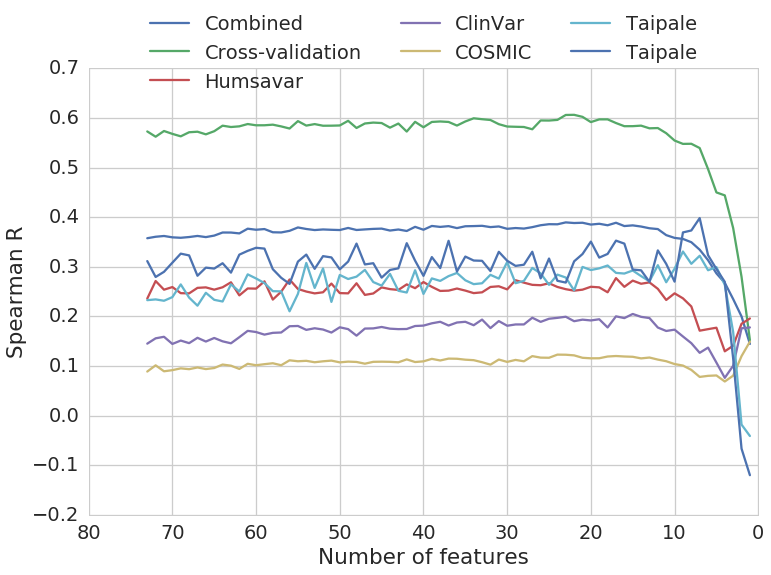

In [57]:
# Train curve for feature elimination
print('Feature elimination on the train dataset')

fg, ax = plt.subplots(figsize=(12, 8))

for test_column, test_label in get_test_columns(suffix_test=''):
    plt.plot(
        feature_elimination_wtest_df['n_features'], 
        feature_elimination_wtest_df[test_column], label=test_label)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()

Feature elimination on the validation dataset


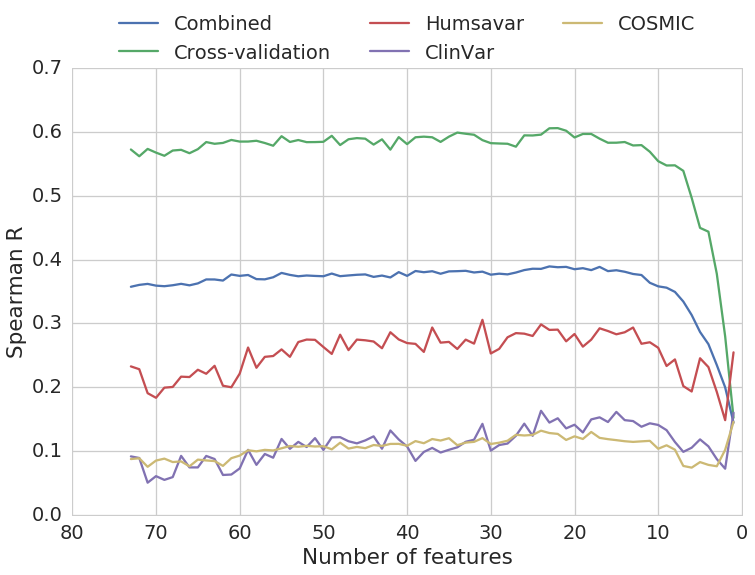

In [58]:
# Validation curve for feature elimination
print("Feature elimination on the validation dataset")

fg, ax = plt.subplots(figsize=(12, 8))

for test_column, test_label in get_test_columns(suffix_test='_test'):
    plt.plot(
        feature_elimination_wtest_df['n_features'], 
        feature_elimination_wtest_df[test_column], label=test_label)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()

In [1]:
# Train + validation curve for feature elimination
DO_TEST = False
test_suffixes = ['', '_test'] if DO_TEST else ['']

df = feature_elimination_wtest_df
fg, ax = plt.subplots(figsize=(12, 8))

plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['spearmanr'], 
         label='Cross-validation', 
         color=sns.palettes.color_palette()[0], 
         linestyle='-')

for test_suffix in test_suffixes:
    plt.plot(feature_elimination_wtest_df['n_features'], 
             feature_elimination_wtest_df['spearmanr_humsavar{}_del_class_exp_vs_ddg'.format(test_suffix)], 
             label='Humsavar' + test_suffix.replace('_', ' ').upper(), 
             color=sns.palettes.color_palette()[1], 
             linestyle='--' if test_suffix else '-')

for test_suffix in test_suffixes:
    plt.plot(df['n_features'], 
             feature_elimination_wtest_df['spearmanr_clinvar{}_del_class_exp_vs_ddg'.format(test_suffix)], 
             label='ClinVar' + test_suffix.replace('_', ' ').upper(),
             color=sns.palettes.color_palette()[2], 
             linestyle='--' if test_suffix else '-')

for test_suffix in test_suffixes:
    plt.plot(feature_elimination_wtest_df['n_features'], 
             feature_elimination_wtest_df['spearmanr_cosmic{}_del_class_exp_vs_ddg'.format(test_suffix)], 
             label='COSMIC' + test_suffix.replace('_', ' ').upper(),
             color=sns.palettes.color_palette()[3],
             linestyle='--' if test_suffix else '-')
    
    
plt.plot(feature_elimination_wtest_df['n_features'], 
     feature_elimination_wtest_df['spearmanr_taipale_ppi_ddg_exp_vs_ddg'], 
     label='Taipale PPI', 
     color=sns.palettes.color_palette()[4],
     linestyle='-')

plt.plot(feature_elimination_wtest_df['n_features'], 
     feature_elimination_wtest_df['spearmanr_taipale_gpca_ddg_exp_vs_ddg'], 
     label='Taipale GPCA', 
     color=sns.palettes.color_palette()[5], 
     linestyle='-',
     linewidth=3)


plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['correlation_avg'], 
         label='Training combined', 
         color='k', 
         linestyle='-',
         linewidth=4)


# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=5)
plt.ylim(0, 0.7)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), ncol=1)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()


n_features_best = df[df['correlation_avg'] == df['correlation_avg'].max()]['n_features'].values[0]
# n_features_best = 14
print('n_features_best', n_features_best)
plt.vlines(n_features_best, 0, 0.6, linestyle='--')

plt.savefig(op.join(NOTEBOOK_NAME, 'feature_elimination.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'feature_elimination.pdf'), bbox_inches='tight')

NameError: name 'feature_elimination_wtest_df' is not defined

In [60]:
feature_elimination_wtest_df.sort_values('correlation_avg').tail(5)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_del_class_exp_vs_ddg_gt80,r2_clinvar_del_class_exp_vs_ddg_lt40,r2_clinvar_test_del_class_exp_vs_ddg,r2_clinvar_test_del_class_exp_vs_ddg_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs,r2_clinvar_test_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_test_del_class_exp_vs_ddg_gt80,r2_clinvar_test_del_class_exp_vs_ddg_lt40,r2_cosmi

In [61]:
N_FEATURES_BEST = (
    feature_elimination_wtest_df[
        feature_elimination_wtest_df['correlation_avg'] == 
            feature_elimination_wtest_df['correlation_avg'].max()
    ]
    .sort_values('n_features', ascending=True)
    .iloc[0]
    ['n_features']
)

In [62]:
N_FEATURES_BEST

23.0

In [63]:
features_best = (
    feature_elimination_wtest_df[
        feature_elimination_wtest_df['n_features'] == N_FEATURES_BEST
    ]['features'].values[0].split(':')
)
features_best

['electrostatics_wt',
 'solvation_polar_wt',
 'entropy_mainchain_wt',
 'partial_covalent_bonds_wt',
 'number_of_residues',
 'intraclashes_energy_1_change',
 'backbone_hbond_change',
 'sidechain_hbond_change',
 'electrostatics_change',
 'solvation_polar_change',
 'solvation_hydrophobic_change',
 'entropy_sidechain_change',
 'entropy_mainchain_change',
 'torsional_clash_change',
 'backbone_clash_change',
 'disulfide_change',
 'pcv_vdw_wt',
 'pcv_salt_opposite_change',
 'pcv_vdw_change',
 'pcv_hbond_self_change',
 'pcv_vdw_self_change',
 'provean_score',
 'solvent_accessibility_change']

In [65]:
clf_options_best = (
    feature_elimination_wtest_df[
        feature_elimination_wtest_df['n_features'] == N_FEATURES_BEST
    ]['clf_opts'].values[0]
)
clf_options_best

{'alpha': 0.7,
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 8,
 'max_features': 1.0,
 'min_samples_leaf': 13,
 'n_estimators': 2000}

In [66]:
# Extract best values
df_best = df[df['correlation_avg'] == df['correlation_avg'].max()]
display(HTML('<b>df_best'), df_best)

# n_features_best = int(df_best['n_features'])
# display(HTML('<b>n_features_best'), n_features_best)

features_best = sorted(df_best['features'].str.split(':').values[0])
display(HTML('<b>features_best'), features_best)

clf_options_best = df_best['clf_opts'].values[0]
display(HTML('<b>clf_options_best'), clf_options_best)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_del_class_exp_vs_ddg_gt80,r2_clinvar_del_class_exp_vs_ddg_lt40,r2_clinvar_test_del_class_exp_vs_ddg,r2_clinvar_test_del_class_exp_vs_ddg_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs,r2_clinvar_test_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_test_del_class_exp_vs_ddg_gt80,r2_clinvar_test_del_class_exp_vs_ddg_lt40,r2_cosmi

['backbone_clash_change',
 'backbone_hbond_change',
 'disulfide_change',
 'electrostatics_change',
 'electrostatics_wt',
 'entropy_mainchain_change',
 'entropy_mainchain_wt',
 'entropy_sidechain_change',
 'intraclashes_energy_1_change',
 'number_of_residues',
 'partial_covalent_bonds_wt',
 'pcv_hbond_self_change',
 'pcv_salt_opposite_change',
 'pcv_vdw_change',
 'pcv_vdw_self_change',
 'pcv_vdw_wt',
 'provean_score',
 'sidechain_hbond_change',
 'solvation_hydrophobic_change',
 'solvation_polar_change',
 'solvation_polar_wt',
 'solvent_accessibility_change',
 'torsional_clash_change']

{'alpha': 0.7,
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 8,
 'max_features': 1.0,
 'min_samples_leaf': 13,
 'n_estimators': 2000}

In [67]:
sorted(features_best)

['backbone_clash_change',
 'backbone_hbond_change',
 'disulfide_change',
 'electrostatics_change',
 'electrostatics_wt',
 'entropy_mainchain_change',
 'entropy_mainchain_wt',
 'entropy_sidechain_change',
 'intraclashes_energy_1_change',
 'number_of_residues',
 'partial_covalent_bonds_wt',
 'pcv_hbond_self_change',
 'pcv_salt_opposite_change',
 'pcv_vdw_change',
 'pcv_vdw_self_change',
 'pcv_vdw_wt',
 'provean_score',
 'sidechain_hbond_change',
 'solvation_hydrophobic_change',
 'solvation_polar_change',
 'solvation_polar_wt',
 'solvent_accessibility_change',
 'torsional_clash_change']

In [68]:
features_best_meta = {
    'backbone_clash_change': 'FoldX backbone clash (mut - wt)',
    'backbone_hbond_change': 'FoldX backbone hydrogen bond (mut - wt)',
    'disulfide_change': 'FoldX disulfide (mut - wt)',
    'electrostatics_change': 'FoldX electrostatics (mut - wt)' ,
    'energy_ionisation_change': 'FoldX ionization energy (mut - wt)',
    'pcv_vdw_self_change': 'ELASPIC PhysicoChemical: number of carbons on the wt chain (mut - wt)',
    'pcv_vdw_self_wt': 'ELASPIC PhysicoChemical: number of carbons on the wt chain (wt)',
    'provean_score': 'Provean deleteriousness score',
    'secondary_structure_wt': 'Stride secondary structure (mut - wt)',
    'solvation_polar_change': 'FoldX solvation energy (mut - wt)',
    'torsional_clash_change': 'FoldX torsional clash change (mut - wt)',
    'van_der_waals_clashes_change': 'FoldX Van der Waals clash change (mut - wt)',
}

In [69]:
xx = pd.set_option('display.max_colwidth', 100)
xx = pd.DataFrame(list(features_best_meta.items()), columns=['feature_name', 'feature_description'])
xx = xx.sort_values('feature_name')
xx

,feature_name,feature_description
0,backbone_clash_change,FoldX backbone clash (mut - wt)
10,backbone_hbond_change,FoldX backbone hydrogen bond (mut - wt)
5,disulfide_change,FoldX disulfide (mut - wt)
9,electrostatics_change,FoldX electrostatics (mut - wt)
4,energy_ionisation_change,FoldX ionization energy (mut - wt)
7,pcv_vdw_self_change,ELASPIC PhysicoChemical: number of carbons on the wt chain (mut - wt)
11,pcv_vdw_self_wt,ELASPIC PhysicoChemical: number of carbons on the wt chain (wt)
6,provean_score,Provean deleteriousness score
8,secondary_structure_wt,Stride secondary structure (mut - wt)
3,solvation_polar_change,FoldX solvation energy (mut - wt)


# Compare with FoldX

In [70]:
try:
    clf_options_best = clf_options_best
except NameError:
    print("Using cached data...")
    clf_options_best = {
        'alpha': 0.95,
        'learning_rate': 0.05,
        'loss': 'huber',
        'max_depth': 10,
        'max_features': 1.0,
        'min_samples_leaf': 5,
        'n_estimators': 2000
    }

In [71]:
try:
    features_best = features_best
except NameError:
    print("Using cached data...")
    features_best = [
        'backbone_clash_change',
        'backbone_hbond_change',
        'backbone_hbond_wt',
        'electrostatic_kon_change',
        'entropy_mainchain_wt',
        'matrix_score',
        'partial_covalent_bonds_wt',
        'pcv_vdw_self_change',
        'pcv_vdw_wt',
        'provean_score',
        'sidechain_hbond_wt',
        'solvation_polar_change',
        'van_der_waals_change',
        'van_der_waals_clashes_change'
    ]

In [72]:
import sklearn
clf = sklearn.ensemble.GradientBoostingRegressor(**clf_options_best)

In [73]:
clf.fit(
    TRAINING_SETS_NONULL['skempi'][features_best],
    TRAINING_SETS_NONULL['skempi']['ddg_exp'])

GradientBoostingRegressor(alpha=0.7, init=None, learning_rate=0.05,
             loss='huber', max_depth=8, max_features=1.0,
             max_leaf_nodes=None, min_samples_leaf=13, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [74]:
TRAINING_SETS_NONULL.keys()

odict_keys(['skempi', 'taipale_ppi_train', 'taipale_gpca_train', 'humsavar_train', 'clinvar_train', 'cosmic_train', 'humsavar_test', 'clinvar_test', 'cosmic_test', 'cagi4_sumo_ligase', 'ab_bind', 'hiv_escape_mutations', 'benedix_et_al'])

In [75]:
print([(key, df.shape) for key, df in TRAINING_SETS_NONULL.items()])

[('skempi', (3368, 166)), ('taipale_ppi_train', (267, 166)), ('taipale_gpca_train', (179, 166)), ('humsavar_train', (5526, 166)), ('clinvar_train', (8339, 166)), ('cosmic_train', (40941, 166)), ('humsavar_test', (2277, 166)), ('clinvar_test', (3580, 166)), ('cosmic_test', (17780, 166)), ('cagi4_sumo_ligase', (3010, 166)), ('ab_bind', (339, 166)), ('hiv_escape_mutations', (23, 166)), ('benedix_et_al', (113, 166))]


In [76]:
for _df in TRAINING_SETS_NONULL.values():
    _df['ddg_pred'] = clf.predict(_df[features_best])

In [77]:
skempi_unique = set(
    TRAINING_SETS_NONULL['skempi']['pdb_id'] + '.' + 
    TRAINING_SETS_NONULL['skempi']['pdb_mutation']
)


def get_title(dataset):
    dataset_dict = {
        'ab_bind': 'AB-Bind',
        'benedix_et_al': 'Benedix',
        'hiv_escape_mutations': 'HIV',
        'taipale_ppi': 'Taipale PPI',
        'taipale_gpca': 'Taipale GPCA',
        'cagi4_sumo_ligase': 'SUMO',
    }
    dataset = dataset.replace('_train', '').replace('_test', '')
    try:
        dataset = dataset_dict[dataset]
    except KeyError:
        dataset = dataset.capitalize()
    return dataset

In [78]:
len(skempi_unique)

1912

humsavar_train
clinvar_train
cosmic_train
taipale_ppi_train
taipale_gpca_train


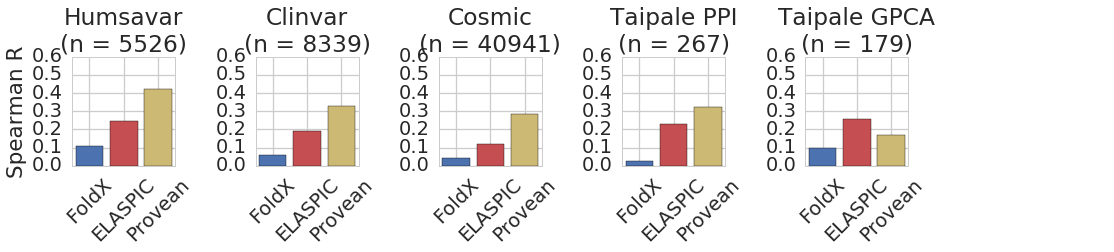

In [79]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 6, figsize=(16, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate([
        # 'skempi', 
        'humsavar_train', 'clinvar_train', 'cosmic_train', 
        'taipale_ppi_train', 'taipale_gpca_train'
    ]):
    print(test_dataset)
    df = TRAINING_SETS_NONULL[test_dataset].copy()
    ax = axes[i]
    if test_dataset != 'skempi':
        _before = df.shape[0]
        df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
        df = df[~df['_unique_id'].isin(skempi_unique)]
        if df.shape[0] != _before:
            print("Lost {} rows due to overlap with Skempi".format(_before - df.shape[0]))

    if test_dataset in ['skempi', 'taipale_ppi_train', 'taipale_gpca_train']:
        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', 'ddg_exp'], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))

        foldx_r = abs(sp.stats.spearmanr(
            vals['dg_change'], 
            vals['ddg_exp'])[0])
        if test_dataset == 'skempi':
            elaspic_r = 0.456105
        else:
            elaspic_r = abs(sp.stats.spearmanr(
                vals['ddg_pred'], 
                vals['ddg_exp'])[0])
        provean_r = abs(sp.stats.spearmanr(
            vals['provean_score'], 
            vals['ddg_exp'])[0])
        title = '{}\n(n = {})'.format(get_title(test_dataset), vals.shape[0])
    else:
        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', 'del_class_exp'], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
            print(df[['dg_change', 'ddg_pred', 'provean_score', 'del_class_exp']].isnull().sum())

        foldx_r = sp.stats.spearmanr(
            vals['dg_change'],  # NO ABS!!!
            vals['del_class_exp'])[0]
        elaspic_r = sp.stats.spearmanr(
            vals['ddg_pred'],  # NO ABS!!!
            vals['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(
            vals['provean_score'], 
            vals['del_class_exp'])[0] * -1
        title = '{}\n(n = {})'.format(get_title(test_dataset), vals.shape[0])
    ax.bar(
        [1, 2, 3], 
        [foldx_r, elaspic_r, provean_r],
        tick_label=['FoldX', 'ELASPIC', 'Provean'],
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[2],
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.6)
    ax.set_title(title)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()


for j in range(i + 1, 6):
    ax = axes[j]
    ax.axis('off')
# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.pdf'), bbox_inches='tight')

humsavar_test
clinvar_test
cosmic_test
cagi4_sumo_ligase
benedix_et_al
Lost 47 rows due to overlap with Skempi
hiv_escape_mutations


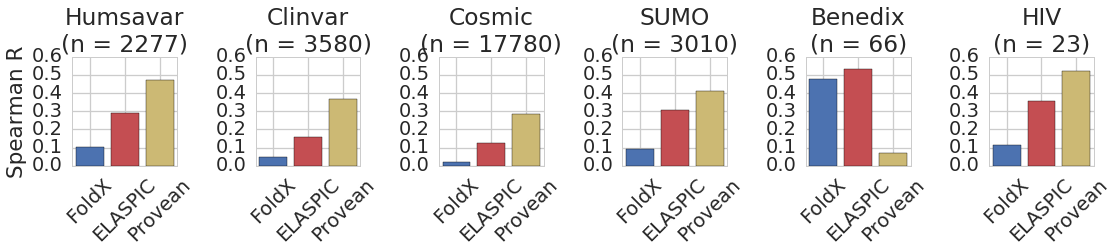

In [80]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 6, figsize=(16, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate([
        # 'skempi', 
        # 'humsavar_train', 'clinvar_train', 'cosmic_train', 
        'humsavar_test', 'clinvar_test', 'cosmic_test', 
        'cagi4_sumo_ligase', 'benedix_et_al', 'hiv_escape_mutations'
    ]):
    print(test_dataset)
    df = TRAINING_SETS_NONULL[test_dataset].copy()
    ax = axes[i]
    if test_dataset != 'skempi':
        _before = df.shape[0]
        df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
        df = df[~df['_unique_id'].isin(skempi_unique)]
        if df.shape[0] != _before:
            print("Lost {} rows due to overlap with Skempi".format(_before - df.shape[0]))

    if test_dataset in ['skempi', 'ab_bind', 'benedix_et_al', 'hiv_escape_mutations']:
        ddg_key = 'ddg_exp'
    elif test_dataset in ['cagi4_sumo_ligase']:
        ddg_key = 'del_score_exp'
    else:
        ddg_key = 'del_class_exp'
        
    vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', ddg_key], how='any')
    if vals.shape[0] != df.shape[0]:
        print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
        print(df[['dg_change', 'ddg_pred', 'provean_score', ddg_key]].isnull().sum())

    foldx_r = abs(sp.stats.spearmanr(
        vals['dg_change'], 
        vals[ddg_key])[0])
    if test_dataset == 'skempi':
        elaspic_r = 0.456105
    else:
        elaspic_r = abs(sp.stats.spearmanr(
            vals['ddg_pred'], 
            vals[ddg_key])[0])
    provean_r = abs(sp.stats.spearmanr(
        vals['provean_score'], 
        vals[ddg_key])[0])
    title = '{}\n(n = {})'.format(get_title(test_dataset), vals.shape[0])

    ax.bar(
        [1, 2, 3], 
        [foldx_r, elaspic_r, provean_r],
        tick_label=['FoldX', 'ELASPIC', 'Provean'],
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[2],
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.6)
    ax.set_title(title)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.pdf'), bbox_inches='tight')